# Fokker-Planck Equation

The **Fokker–Planck equation**, also known as the **Kolmogorov Forward Equation**, describes the time evolution of the probability density function of a stochastic process. In finance, it plays a key role in modeling the dynamics of asset prices, interest rates, and other financial variables under uncertainty. It has vast applications in the form of option pricing, risk management, interest rate models as well as stochastic volatility model.

Let $(\Omega, \mathcal{G}, \mathbb{G}_t\, \mathbb{P})$ be a filtered probability space. <br>
For a stochastic process $ X_t: \mathbb{R} \times \Omega \rightarrow \mathbb{R}$  governed by an Itô diffusion:

$$
dX_t = \mu(X_t, t) dt + \sigma(X_t, t) dW_t
$$

The Kolmogorov Forward Equation for the probability density $p(x, t)$ is:

$$
\frac{\partial p(x, t)}{\partial t} = -\frac{\partial}{\partial x}[\mu(x, t) p(x, t)] + \frac{1}{2} \frac{\partial^2}{\partial x^2}[\sigma^2(x, t) p(x, t)]
$$

- The **drift term** $\mu(x, t)$ shifts the distribution.
- The **diffusion term** $\sigma(x, t)$ spreads it out.
- Over time, the equation captures how uncertainty and randomness affect the likelihood of different outcomes


## 1. Evolution of pdf using analytical solution of GBM

Suppose we have an assest $X_t$ that has a geometric brown motion setup, where $\mu$ and $\sigma$ are constants, the SDE and analytical solution is shown below.
$$
dX_t = \mu X_tdt + \sigma X_tdW_t
$$

$$X_t =X_0 \cdot \exp\left[ \left( \mu - \frac{1}{2} \sigma^2 \right)t + \sigma W_t \right]
$$

Since $ \ln X_t \sim \mathcal{N} \left( \ln X_0 + \left( \mu - \frac{1}{2} \sigma^2 \right)t, \, \sigma^2 t \right) $, the PDF of $ X_t $ is:

$$
f_{X_t}(x) = \frac{1}{x \sigma \sqrt{2\pi t}} \exp\left( -\frac{\left[ \ln(x/X_0) - \left( \mu - \frac{1}{2} \sigma^2 \right)t \right]^2}{2 \sigma^2 t} \right) for \ x > 0.
$$

The formula of the log-normal pdf can be obtained using a change of variable formula.

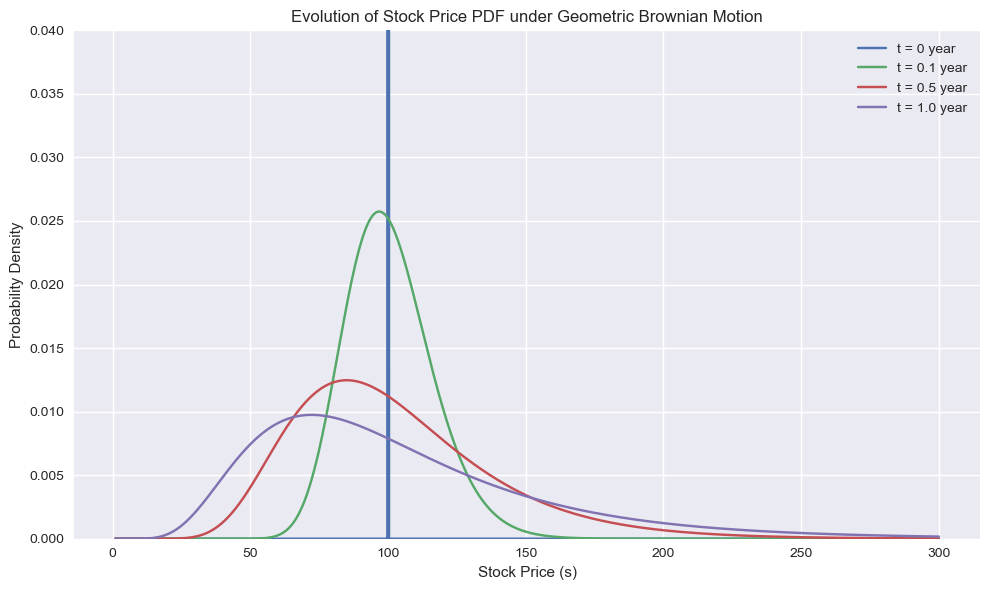

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
X0 = 100
mu = 0.05
sigma = 0.5
time_points = [0, 0.1, 0.5, 1.0]
x = np.linspace(1, 300, 1000)

# Lognormal PDF function
def gbm_pdf(x, t, X0, mu, sigma):
    factor = 1 / (x * sigma * np.sqrt(2 * np.pi * t))
    exponent = - (np.log(x / X0) - (mu - 0.5 * sigma**2) * t)**2 / (2 * sigma**2 * t)
    return factor * np.exp(exponent)

# Plotting
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

for t in time_points:
    if t == 0:
        pdf = gbm_pdf(x, 1e-6, X0, mu, sigma)

    else:
        pdf = gbm_pdf(x, t, X0, mu, sigma)
    plt.plot(x, pdf, label=f't = {t} year')

plt.title('Evolution of Stock Price PDF under Geometric Brownian Motion')
plt.xlabel('Stock Price (s)')
plt.ylabel('Probability Density')
plt.ylim(0,0.04)
plt.legend()
plt.grid(True)
plt.tight_layout()

Based on the log-normal formula, we know that as time goes from 0 to 0.1 to 0.5 to 1, the variance increases, resulting in a wider and more right skewed distribution. At time = 0, the asset price is known to be $100, hence a dirac delta function. As time progresses, the distribution of stock price is more spread out.  

## 2. Fokker–Planck PDE — General Discretization & θ-Scheme

### PDE (Fokker–Planck)
For a geometric Brownian motion
$$
dX_t = \mu X_t\,dt + \sigma X_t\,dW_t,
$$
the **probability density** \(p(X,t)\) satisfies:
$$
\boxed{\;\frac{\partial p}{\partial t} \;=\;
-\frac{\partial}{\partial X}(\mu X\,p)
\;+\; \frac{1}{2}\frac{\partial^2}{\partial X^2}(\sigma^2 X^2\,p)\; }.
$$

We can rewrite the Fokker-Planck PDE in the Conservative (flux) form for easier discretization:
$$
\frac{\partial p}{\partial t} = -\frac{\partial J}{\partial X},\qquad
J(X,t) := \mu X\,p - \frac{\partial}{\partial X}\!\big(D(X)p\big),
$$
with diffusion function
$$
D(X) := \tfrac12\sigma^2 X^2.
$$

---

### Grid and notation
Space and time grids:
$$
X_i = i\Delta X,\quad i=0,\dots,M,\qquad
t^n = n\Delta t,\quad n=0,\dots,N.
$$

Discrete density:
$$
p_i^n \approx p(X_i, t^n).
$$

 The interface is the point between i and i+1:
$$
X_{i+\frac12} = \tfrac12 (X_i + X_{i+1}).
$$

---

### Interface flux discretization
For the flux discretization, we will be using the explicit schemes. <br>
At interface ${i+\tfrac12}$:
$$
\begin{aligned}
(\mu X p)_{i+\frac12}
&\approx \mu\,X_{i+\frac12}\,\frac{p_{i+1}+p_i}{2},\\[4pt]
\frac{\partial}{\partial X}(Dp)\Big|_{i+\frac12}
&\approx \frac{D_{i+1}p_{i+1} - D_i p_i}{\Delta X}.
\end{aligned}
$$

Thus the flux:

$$
J_{i+\frac12} \approx
\mu X_{i+\frac12}\frac{p_{i+1}+p_i}{2}
- \frac{D_{i+1}p_{i+1}-D_i p_i}{\Delta X}.
$$

At interface ${i-\tfrac12}$:

$$
J_{i-\frac12} \approx
\mu X_{i-\frac12}\frac{p_{i-1}+p_i}{2}
- \frac{D_{i}p_{i}-D_{i-1} p_{i-1}}{\Delta X}.
$$ 

---

### Finite-volume update (θ-scheme)
General θ-scheme for the conservation law:
$$
\frac{p_i^{n+1}-p_i^n}{\Delta t}
= -\frac{J_{i+\frac12}^{\,n+\theta}-J_{i-\frac12}^{\,n+\theta}}{\Delta X},
$$
with
$$
J^{\,n+\theta} = \theta J^{\,n+1} + (1-\theta)J^n,\qquad \theta\in[0,1].
$$

**Special choices**
- `θ = 0`: Explicit Scheme 
- `θ = 1`: Implicit Scheme  
- `θ = 0.5`: Crank–Nicolson  

Note: The Crank_Nicolson scheme is just the average of the explicit and the implicit scheme with $O(\Delta t^2, \Delta x^2)$, hence the `θ = 0.5`. 

Operator form:

$$
\Big(I - \theta\Delta t\,L\Big)p^{n+1}
=
\Big(I + (1-\theta)\Delta t\,L\Big)p^{n},
$$

where \(L\) is the discretized spatial operator.

---

### Tridiagonal stencil for `Lp`
Let
$$
D_i := \tfrac12\sigma^2 X_i^2.
$$

The spatial operator has the form
$$
(Lp)_i \approx a_i p_{i-1} + b_i p_i + c_i p_{i+1}.
$$

For uniform spacing:

$$
\begin{aligned}
a_i &= \frac{D_{i-1}}{\Delta X^2}
      + \frac{\mu X_{i-1}}{2\Delta X},
\\
b_i &= -\frac{2D_i}{\Delta X^2},
\\
c_i &= \frac{D_{i+1}}{\Delta X^2}
      - \frac{\mu X_{i+1}}{2\Delta X}.
\end{aligned}
$$

These coefficients assemble the tridiagonal matrix `L`.

---

### Boundary conditions

#### 1. Dirichlet (absorbing)
$$
p_0^n = 0,\qquad p_M^n = 0.
$$

#### 2. No-flux (Neumann)
$$
J(X_b,t) = 0
\quad \Rightarrow\quad
\mu X_b p - \partial_X(Dp)\big|_{X_b}=0.
$$

In implementation: enforce directly by modifying the first/last rows of the linear system.

---

## Matrices for each time step
Construct:

$$
A = I - \theta\Delta t\,L,\qquad
B = I + (1-\theta)\Delta t\,L.
$$

Time step:

$$
A\,p^{n+1} = B\,p^{n}.
$$

Since \(A\) is tridiagonal, solve efficiently using a Thomas solver or sparse LU.

---

## Initial condition
Approximate a delta at \(X_0\) by a narrow Gaussian:
$$
p_i^0 \propto \exp\!\Big(-\frac{(X_i - X_0)^2}{2\varepsilon^2}\Big).
$$

Normalize so that:
$$
\sum_i p_i^0\,\Delta X = 1.
$$

---

## Analytical solution for comparison
The exact GBM density at time \(T\) is lognormal:
$$
p(X,T) =
\frac{1}{X\sqrt{2\pi\sigma^2T}}
\exp\!\left(
-\frac{
\big(\ln X - \ln X_0 - (\mu-\tfrac12\sigma^2)T\big)^2
}{2\sigma^2 T}
\right).
$$

---

## Python assembly sketch
```python
theta = 0.5  # CN
D = 0.5 * sigma**2 * X**2

a = np.zeros(M+1)
b = np.zeros(M+1)
c = np.zeros(M+1)

for i in range(1, M):
    a[i] = D[i-1]/dX**2 + mu*X[i-1]/(2*dX)
    b[i] = -2*D[i]/dX**2
    c[i] = D[i+1]/dX**2 - mu*X[i+1]/(2*dX)

# assemble L and form A = I - theta*dt*L, B = I + (1-theta)*dt*L
# then solve A p_next = B p each timestep


C:\Users\ojw_m\AppData\Local\Temp\ipykernel_2748\3231303335.py:13: RuntimeWarning: divide by zero encountered in divide
  factor = 1 / (x * sigma * np.sqrt(2 * np.pi * t))
C:\Users\ojw_m\AppData\Local\Temp\ipykernel_2748\3231303335.py:14: RuntimeWarning: divide by zero encountered in log
  exponent = - (np.log(x / X0) - (mu - 0.5 * sigma**2) * t)**2 / (2 * sigma**2 * t)
C:\Users\ojw_m\AppData\Local\Temp\ipykernel_2748\3231303335.py:15: RuntimeWarning: invalid value encountered in multiply
  return factor * np.exp(exponent)


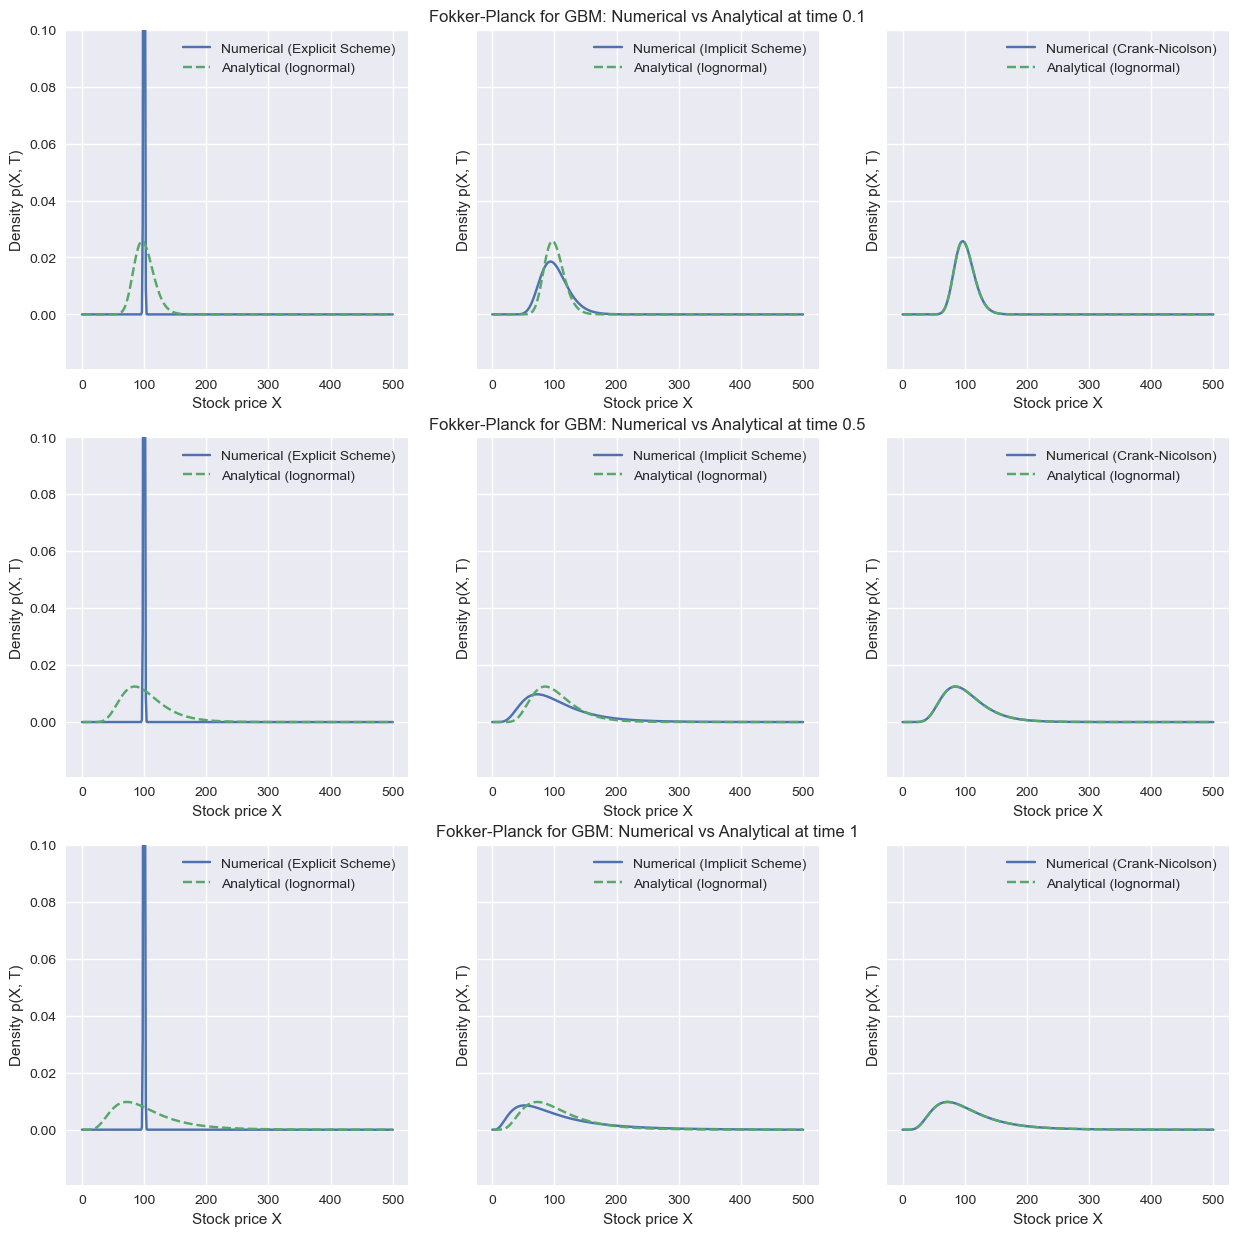

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import splu

# Parameters
X0 = 100.0
mu = 0.05
sigma = 0.5
T = 1.0

# Spatial grid
X_max = 5 * X0
Nx = 400
X = np.linspace(0, X_max, Nx)
dX = X[1] - X[0]

# Time grid
Nt = 2001
dt = T / Nt

# Avoid X=0 for analytic formula
X_pos = X.copy()
X_pos[0] = 1e-8

# Initial condition: narrow Gaussian at S0
eps = X0 * 0.01
p0 = np.exp(-0.5 * ((X - X0) / eps) ** 2)
p0 /= np.sum(p0) * dX

# Construct operator L for the RHS of PDE
D = 0.5 * sigma**2 * X_pos**2
lower = np.zeros(Nx)
diag  = np.zeros(Nx)
upper = np.zeros(Nx)

for i in range(1, Nx-1):
    coef_a =  (mu * X_pos[i-1])/(2*dX) + D[i-1]/(dX**2)
    coef_b =  -2 * D[i]/(dX**2)
    coef_c = -(mu * X_pos[i+1])/(2*dX) + D[i+1]/(dX**2)
    lower[i] = coef_a
    diag[i]  = coef_b
    upper[i] = coef_c

# boundary rows
diag[0] = 1.0
diag[-1] = 1.0

offsets = [-1, 0, 1]
data = [lower[1:], diag, upper[:-1]]
L = diags(data, offsets, shape=(Nx, Nx), format='csc')

theta_of_int = {0: "Explicit Scheme",1: "Implicit Scheme",0.5: "Crank-Nicolson"}
thetas = list(theta_of_int.keys())

time_of_int = [0.1,0.5,1]

fig,axes = plt.subplots(3, 3, figsize=(15, 15),sharey=True)

for i,T in enumerate(time_of_int):    
    dt = T / Nt
    
    for j, theta in enumerate(thetas):

        scheme_name = theta_of_int[theta]
        ax = axes[i, j]    

        I = diags([np.ones(Nx)], [0], format='csc')
        A = (I - theta * dt * L).tocsc()
        B = (I + theta * dt * L).tocsc()
        lu = splu(A)
    
        # Time stepping
        p = p0.copy()
        for time in range(Nt):
            rhs = B.dot(p)
            rhs[0] = 0.0
            rhs[-1] = 0.0
            p = lu.solve(rhs)
            p[p < 0] = 0.0
            p /= (np.sum(p) * dX)


        ax.plot(X, p, label= f'Numerical ({scheme_name})')
        ax.plot(X, gbm_pdf(X, T, X0, mu, sigma), label='Analytical (lognormal)', linestyle='--')
        
        ax.set_xlabel('Stock price X')
        ax.set_ylabel('Density p(X, T)')
        ax.set_ylim(top = 0.1)
        if j == 1:
            ax.set_title(f'Fokker-Planck for GBM: Numerical vs Analytical at time {T}')
        ax.legend()
        ax.grid(True)

# 3. Conclusion

The Crank–Nicolson (CN) scheme outperforms both explicit and fully implicit finite difference methods when solving the Fokker–Planck equation for the geometric Brownian motion (GBM) distribution due to its superior balance between stability and accuracy. While explicit schemes are conditionally stable and require prohibitively small time steps to maintain numerical stability—especially in the presence of steep gradients near absorbing boundaries—CN is unconditionally stable and second-order accurate in both time and space. Compared to the fully implicit scheme, which is also unconditionally stable but only first-order accurate in time, CN offers significantly improved temporal accuracy without sacrificing stability. This makes CN particularly well-suited for capturing the evolving probability density of GBM, which often exhibits sharp features such as moving peaks or absorbing boundaries. Moreover, CN's time-centered discretization better preserves the conservation properties and smoothness of the solution, which are critical for accurately modeling the probabilistic dynamics governed by the Fokker–Planck equation.